In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

Text(0, 0.5, 'dN/dE $\\times E^{2.5}\\ (GeV)^{1.5}$')

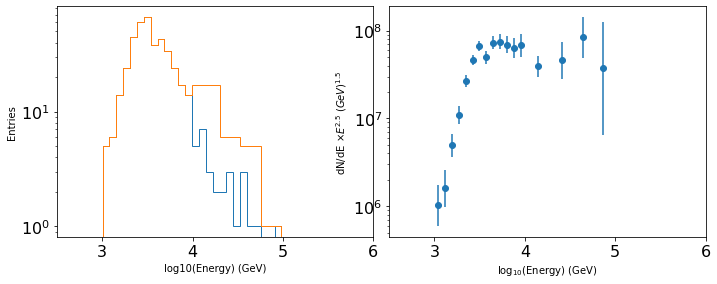

In [21]:
#Load a TF model
models = sorted(glob.glob('./models/*.h5'))
model_current = [models[0], models[1], models[2], models[3], models[4]] #x1.5, x1, x2, x3, x4
model_name = 1
model = tf.keras.models.load_model(model_current[model_name])

#Load data
Imgs = np.load('./Fe_Flux/data/FeFL_8-120-SCD0_imgs.npy')
Angles = np.load('./Fe_Flux/data/FeFL_8-120-SCD0_angles.npy')
X = Imgs
X0 = Angles

#Reshape data
img_rows, img_cols = X[0].shape
input_shape = (img_rows, img_cols, 1)
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = X.astype('float32')
X0 = np.reshape(Angles, (len(X0),1))

#Make predictions
prediction = model.predict([X, X0])
Energy_ML = np.reshape(prediction, (len(prediction), ))

from astropy.visualization import hist

#https://docs.astropy.org/en/stable/api/astropy.stats.knuth_bin_width.html#astropy.stats.knuth_bin_width
plt.figure(figsize=(10, 4))
plt.subplot(121)
h0 = hist(Energy_ML, bins = 'knuth', histtype='step')

#modify bin width from 'knuth' to ensure each bin has >5 entries
adj_models = [12, 13, 12, 11, 10]
adj_idx = adj_models[model_name]
bin_width = (h0[1][-1]-h0[1][-adj_idx])/4

bin_append = []
for i in [1,2,3,4]:
    bin_append.append(h0[1][-adj_idx] + i*bin_width)
bin_append = np.array(bin_append)

bins = h0[1][:-adj_idx]
bins_new = np.append(bins, bin_append)



h0 = hist(Energy_ML, bins = bins_new, histtype='step')

plt.yscale('log')
plt.xlim(2.5, 6)
plt.xlabel('log10(Energy) (GeV)')
plt.ylabel('Entries')  
plt.tight_layout()

x0 = []
for i in range(1, len(h0[1])):
    x0.append( (h0[1][i] + h0[1][i-1])/2 ) #bin center in log10(GeV)
x0 = np.array(x0)

dE = []
for j in range(1, len(h0[1])):
    dE.append(10**h0[1][j] - 10**h0[1][j-1]) #bin size in GeV
dE = np.array(dE)

gamma = 2.5
y0 = h0[0]/dE*(10**x0)**gamma
#Error calculation
#https://docs.astropy.org/en/stable/api/astropy.stats.poisson_conf_interval.html
from astropy import stats
y0_lo_err0 = y0 - (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence'))[0]/dE*(10**x0)**gamma
y0_up_err0 = (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence'))[1]/dE*(10**x0)**gamma - y0
y0_up_err1 = (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence',sigma=2))[1]/dE*(10**x0)**gamma - y0

plt.subplot(122)

zero_data = np.logical_not(y0.astype('bool')) #data points with zero entries
zero_idx = np.where(zero_data==True)[0]
x_zero_data = x0[zero_idx]
y_zero_data = y0_up_err1[zero_idx]
uplims = np.array([1 for _ in range(len(zero_idx))], dtype=bool)

idx = np.where(y0.astype('bool')==True)[0] #data points with non-zero entries

plt.errorbar(x0[idx], y0[idx], yerr = [y0_lo_err0[idx], y0_up_err0[idx]], marker='o', linestyle='')
#plt.errorbar(x_zero_data, y_zero_data, yerr = y_zero_data/1.5, uplims=uplims, marker=7,linestyle='')

plt.yscale('log')
plt.xlim(2.5, 6)
#plt.ylim(1e-6, 1)

plt.xlabel(r'$\rm log_{10}$(Energy) (GeV)')
plt.ylabel(r'dN/dE $\times E^{2.5}\ (GeV)^{1.5}$') 


<ipython-input-23-24fa7effc349>:17: RuntimeWarning: divide by zero encountered in true_divide
  y = y0/(e*G*t)
<ipython-input-23-24fa7effc349>:26: RuntimeWarning: divide by zero encountered in true_divide
  y_err_up = y0_up_err0/(e*G*t)
<ipython-input-23-24fa7effc349>:27: RuntimeWarning: divide by zero encountered in true_divide
  y_err_lo = y0_lo_err0/(e*G*t)
<ipython-input-23-24fa7effc349>:53: RuntimeWarning: invalid value encountered in true_divide
  systematic2_y = abs(y)*np.sqrt( (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
<ipython-input-23-24fa7effc349>:137: RuntimeWarning: invalid value encountered in true_divide
  systematic2_y = abs(y)*np.sqrt( (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )


Text(0.5, 1.0, 'Fe flux $\\times$ (E/nucleon)$^{2.5}$')

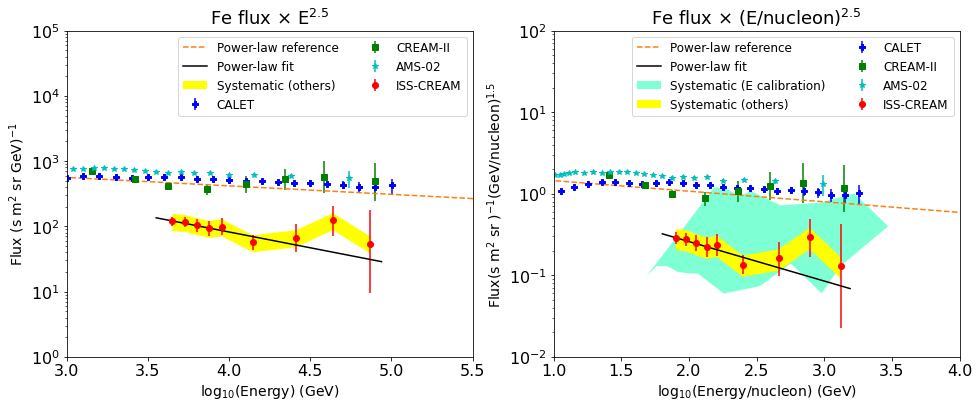

In [23]:
x = x0

A0 = 0.364358
A1 = 3.29957
A2 = 0.135761
G = A0*(1 - np.exp(-(x-A1)/A2))*np.heaviside(x-A1, 0)

#t = 13996800
t = 6938784
#e = 0.32*0.40
B0 = 0.60986744
B1 = 3.30849844
B2 = 0.11200669
e_cut = B0*(1 - np.exp(-(x-B1)/B2))*np.heaviside(x-B1, 0)
e = 0.45*e_cut # 8-120 + charge selection (24.5 < Z of SCD0 < 28)

y = y0/(e*G*t)

#Don't propagate systematic error to statistical error!!
e_err = 0.2*e
G_err = 0.15*0.35
t_err = 0.15*t
#y_err_up = abs(y)*np.sqrt( (y0_up_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
#y_err_lo = abs(y)*np.sqrt( (y0_lo_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )

y_err_up = y0_up_err0/(e*G*t)
y_err_lo = y0_lo_err0/(e*G*t)


#plot data
plt.figure(figsize=(16,6))

start_model = [7, 8 ,5, 3, 2]
start_idx = start_model[model_name]

plt.subplot(121) #GeV per nucleus

'''
#plot systematic upper error due to energy scale (x2, or x12)
systematic1_up_x, systematic1_up_y = np.load('./Fe_Flux/result/systematicX2_up.npy', allow_pickle=True)
x1, x2 = x0[start_idx:], systematic1_up_x
y1, y2 = y[start_idx:], systematic1_up_y
plt.fill(np.append(x1, x2[::-1]), np.append(y1, y2[::-1]), 'aquamarine', label='Systematic (E calibration)')

#plot systematic lower error due to energy scale (x0.5, or x3)
x5, x6 = x0[start_idx-1:]-0.14, x0[start_idx:]
flux_lower_factor = np.random.random_sample(len(y[start_idx-1:],))*(1.4-1.3)+1.3
y5, y6 = y[start_idx-1:]/(flux_lower_factor*10**(0.14*1.5)), y[start_idx:]
plt.fill(np.append(x5, x6[::-1]), np.append(y5, y6[::-1]), 'aquamarine')
'''

#plot systematic error due to livetime and GF
systematic2_y = abs(y)*np.sqrt( (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
x3 = x0[start_idx:]
y3, y4 = y[start_idx:] - systematic2_y[start_idx:], y[start_idx:] + systematic2_y[start_idx:]
plt.fill(np.append(x3, x3[::-1]), np.append(y3, y4[::-1]), 'yellow', label='Systematic (others)')


#plot reference power law
E = np.logspace(2,6) #in GeV
phi0 = 1.78*1e-2
a = 2.63
phi = 1e-3*phi0*(E/1e3)**(-a)
gamma = 2.5
plt.plot(np.log10(E), phi*E**gamma, linestyle='dashed', color='C1',label='Power-law reference')


#plot fitted line
best_pars0, best_pars1 = np.load('./Fe_Flux/result/x1_PL_fit.npy', allow_pickle=True)
def fit_func(x, Phi0, alpha):
    return 1e-3*Phi0*(x/1e3)**(-alpha)

fit_idx = np.where ((np.log10(E) > 3.55) & (np.log10(E) < 5.02 )) [0] #only cover data points x1
#fit_idx = np.where ((np.log10(E) > 3.85) & (np.log10(E) < 5.5 )) [0] #only cover data points x2

plt.plot(np.log10(E)[fit_idx], fit_func(E[fit_idx], best_pars0, best_pars1)*E[fit_idx]**gamma, \
         color='black', label='Power-law fit') 



#reference experiments
calet = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/CALET_iron_2021.dat', format='ascii')
ams = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/table-si.csv', format='ascii')
cream = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/cream_ii.txt', format='ascii')

#CALET
calet_E = (calet['col1']+calet['col2'])/2
plt.errorbar( np.log10(calet_E)+np.log10(56), calet['col3']*calet_E**2.5/56**(-1.5), 
              yerr=calet['col4']*calet_E**2.5/56**(-1.5), ls='none', color='b', marker='P', label='CALET')
#CREAM-II
cream_E = cream['Kinetic_Energy_(GeV/n)']
plt.errorbar( np.log10(cream_E)+np.log10(56), cream['Intensity_(m2_sr_s_GeV/n)-1']*cream_E**2.5/56**(-1.5),
              yerr=[cream['lo_error']*cream_E**2.5/56**(-1.5), cream['up_error']*cream_E**2.5/56**(-1.5)], 
              ls='none', color='g', marker='s', label='CREAM-II')
#AMS
ams_R = (ams['rigidity_max GV'] + ams['rigidity_min GV'])/2
ams_E = ams_R/(56/26)

plt.errorbar( np.log10(ams_E)+np.log10(56), ams['iron_flux m^-2sr^-1s^-1GV^-1']*ams_R**2.5*(56/26)**(-1.5)/56**(-1.5),
              yerr=ams['iron_flux_error_statistical m^-2sr^-1s^-1GV^-1']*ams_R**2.5*(56/26)**(-1.5)/56**(-1.5), 
              ls='none',color='c', marker='*',label='AMS-02')

#ISS-CREAM
plt.errorbar(x0[start_idx:], y[start_idx:], \
             yerr=[y_err_lo[start_idx:], y_err_up[start_idx:]], \
             marker='o', linestyle='',color='red', label='ISS-CREAM')


plt.yscale('log')
plt.xlim(3, 5.5)
plt.ylim(1, 1e5)
plt.legend(ncol=2, fontsize=12)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.xlabel(r'$\rm log_{10}$(Energy) (GeV)',fontsize=14)
plt.ylabel(r'Flux $(\rm s\ m^2\ sr\ GeV)^{-1}$',fontsize=14)
plt.title(r'Fe flux $\times$ E$^{2.5}$',fontsize=18)


plt.subplot(122)


#plot systematic upper error due to energy scale (x2, or x12)
systematic1_up_x, systematic1_up_y = np.load('./Fe_Flux/result/systematicX2_up.npy', allow_pickle=True)
x1, x2 = x0[start_idx:]-np.log10(56), systematic1_up_x-np.log10(56)
y1, y2 = y[start_idx:]*56**(-1.5), systematic1_up_y*56**(-1.5)
plt.fill(np.append(x1, x2[::-1]), np.append(y1, y2[::-1]), 'aquamarine', label='Systematic (E calibration)')

#plot systematic lower error due to energy scale (x0.5, or x3)
x5, x6 = x0[start_idx-1:]-0.14-np.log10(56), x0[start_idx:]-np.log10(56)
flux_lower_factor = np.random.random_sample(len(y[start_idx-1:],))*(1.4-1.3)+1.3
y5, y6 = y[start_idx-1:]/(flux_lower_factor*10**(0.14*1.5))*56**(-1.5), y[start_idx:]*56**(-1.5)
plt.fill(np.append(x5, x6[::-1]), np.append(y5, y6[::-1]), 'aquamarine')


#plot systematic error due to livetime and GF
systematic2_y = abs(y)*np.sqrt( (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
x3 = x0[start_idx:]-np.log10(56)
y3 = y[start_idx:]*56**(-1.5) - systematic2_y[start_idx:]*56**(-1.5)
y4 = y[start_idx:]*56**(-1.5) + systematic2_y[start_idx:]*56**(-1.5)
plt.fill(np.append(x3, x3[::-1]), np.append(y3, y4[::-1]), 'yellow', label='Systematic (others)')


#reference power law
plt.plot(np.log10(E)-np.log10(56), phi*E**gamma*56**(-1.5), linestyle='dashed', color='C1',label='Power-law reference')

#fitted line
plt.plot(np.log10(E)[fit_idx]-np.log10(56), \
         fit_func(E[fit_idx], best_pars0, best_pars1)*E[fit_idx]**gamma*56**(-1.5), \
         color='black', label='Power-law fit') 


#reference experiments
calet = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/CALET_iron_2021.dat', format='ascii')
ams = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/table-si.csv', format='ascii')
cream = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/cream_ii.txt', format='ascii')

#CALET
calet_E = (calet['col1']+calet['col2'])/2
plt.errorbar( np.log10(calet_E), calet['col3']*calet_E**2.5, 
              yerr=calet['col4']*calet_E**2.5, ls='none', color='b', marker='P', label='CALET')
#CREAM-II
cream_E = cream['Kinetic_Energy_(GeV/n)']
plt.errorbar( np.log10(cream_E), cream['Intensity_(m2_sr_s_GeV/n)-1']*cream_E**2.5,
              yerr=[cream['lo_error']*cream_E**2.5, cream['up_error']*cream_E**2.5], 
              ls='none', color='g', marker='s', label='CREAM-II')
#AMS
ams_R = (ams['rigidity_max GV'] + ams['rigidity_min GV'])/2
ams_E = ams_R/(56/26)

plt.errorbar( np.log10(ams_E), ams['iron_flux m^-2sr^-1s^-1GV^-1']*ams_R**2.5*(56/26)**(-1.5),
              yerr=ams['iron_flux_error_statistical m^-2sr^-1s^-1GV^-1']*ams_R**2.5*(56/26)**(-1.5), 
              ls='none',color='c', marker='*',label='AMS-02')

#ISS-CREAM
plt.errorbar(x0[start_idx:]-np.log10(56), y[start_idx:]*56**(-1.5), \
             yerr=[y_err_lo[start_idx:]*56**(-1.5), y_err_up[start_idx:]*56**(-1.5)], \
             color='red', marker='o', linestyle='', label='ISS-CREAM')
#plt.errorbar(x_zero_data-np.log10(56), y_zero_data*56**(-1.5)/(0.61*0.35*t), \
#             yerr = y_zero_data*56**(-1.5)/(0.61*0.35*t)/1.5, uplims=uplims, marker=7,linestyle='',color='red')


plt.yscale('log')
plt.xlim(1, 4)
plt.ylim(1e-2, 1e2)
plt.legend(ncol=2, fontsize=12)
plt.xlabel(r'$\rm log_{10}$(Energy/nucleon) (GeV)',fontsize=14)
plt.ylabel(r'$\rm Flux (s\ m^2\ sr\ )^{-1}(GeV/nucleon)^{1.5}$',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.title(r'Fe flux $\times$ (E/nucleon)$^{2.5}$',fontsize=18)


In [ ]:
#x2 only
#systematic_up = [x0[start_idx:], y[start_idx:]]
#np.save('./Fe_Flux/result/systematic_up.npy', systematic_up)

Text(0.5, 1.0, 'Fe flux $\\times$ E$^{2.5}$')

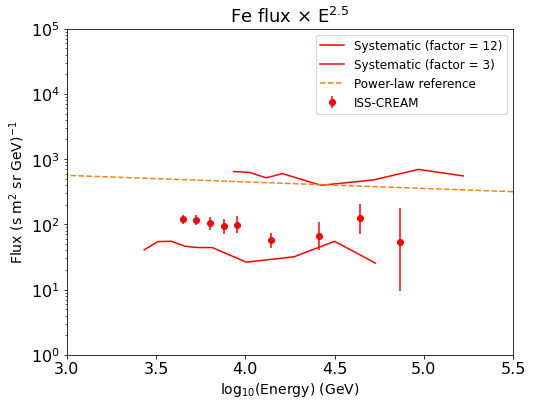

In [49]:
#ISS-CREAM total error band
plt.figure(figsize=(8,6))

plt.errorbar(x0[start_idx:], y[start_idx:], \
             yerr=[y_err_lo[start_idx:], y_err_up[start_idx:]], \
             marker='o', linestyle='',color='red', label='ISS-CREAM')

#plot total upper error due to energy scale (x2, or x12)
total_err_up_x_buf, total_err_up_y_buf = \
                np.load('./Fe_Flux/result/total_up.npy', allow_pickle=True) #systematic + statistic x2 only
total_err_up_x = 
total_err_up_y
plt.plot(total_err_up_x, total_err_up_y, '-', color='red', label='Total uncertainty')

#plot total lower error due to energy scale (x0.5, or x3)
x5 = x0[start_idx-1:]-0.14
flux_lower_factor = np.random.random_sample(len(y[start_idx-1:],))*(1.4-1.3)+1.3
y5= y[start_idx-1:]/(flux_lower_factor*10**(0.14*1.5))
plt.plot(x5, y5, '-', color='red')

plt.plot(np.log10(E), phi*E**gamma, linestyle='dashed', color='C1',label='Power-law reference')

plt.yscale('log')
plt.xlim(3, 5.5)
plt.ylim(1, 1e5)
plt.legend(fontsize=12)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.xlabel(r'$\rm log_{10}$(Energy) (GeV)',fontsize=14)
plt.ylabel(r'Flux $(\rm s\ m^2\ sr\ GeV)^{-1}$',fontsize=14)
plt.title(r'Fe flux $\times$ E$^{2.5}$',fontsize=18)
